#### Import packages

In [1]:
import os
import pandas as pd
import numpy as np
from PIL import Image
import torch
from torch.utils.data import Dataset
from torchvision import transforms
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import ExponentialLR
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score, roc_curve, auc

#### Load the dataset and preprocess the images

In [2]:
class MHISTDataset(Dataset):
    def __init__(self, img_dir, labels_file, transform=None):
        self.img_dir = img_dir
        self.labels = pd.read_csv(labels_file)
        self.transform = transform
        
    def __len__(self):
        return len(self.labels)
        
    def __getitem__(self, idx):
        img_name = os.path.join(self.img_dir, self.labels.iloc[idx, 0])  # Image names from the first column
        image = Image.open(img_name)
        
        # Map 'hp' and 'ssa' to integer labels
        label = 0 if self.labels.iloc[idx, 1] == 'HP' else 1  # Assuming 'HP' -> 0 and 'SSA' -> 1
        confidence = self.labels.iloc[idx, 2] / 7.0
        
        if self.transform:
            image = self.transform(image)
        
        return image, label, confidence

In [3]:
# Define the transformations
augmentation = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
    transforms.ToTensor()
])

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

# Path to images and the CSV file
img_dir = '../data/images'
labels_file = '../data/annotations.csv'

# Load the CSV file and split based on the 'Partition' column
annotations = pd.read_csv(labels_file)
train_data = annotations[annotations['Partition'] == 'train']
test_data = annotations[annotations['Partition'] == 'test']

# Save the train and test splits into separate CSV files (if needed)
train_data.to_csv('train_annotations.csv', index=False)
test_data.to_csv('test_annotations.csv', index=False)

# Create Dataset instances
train_dataset = MHISTDataset(img_dir=img_dir, labels_file='train_annotations.csv', transform=augmentation)
test_dataset = MHISTDataset(img_dir=img_dir, labels_file='test_annotations.csv', transform=transform)

# Create DataLoader instances
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=True)

#### Define the various models

In [4]:
class MHISTModel(nn.Module):
    def __init__(self):
        super(MHISTModel, self).__init__()
        self.conv1 = nn.Conv2d(3, 10, kernel_size=7, padding=0)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(10, 10, kernel_size=7, padding=0)
        self.dropout = nn.Dropout(0.5)

        # Final fully connected layer - output 1 unit for binary classification
        self.fc1 = None  # Will initialize dynamically based on input size

    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))  # Conv -> Relu -> Pooling
        x = self.pool(torch.relu(self.conv2(x)))  # Conv -> Relu -> Pooling
            
        # Calculate the flattened size dynamically
        if self.fc1 is None:
            num_features = x.size(1) * x.size(2) * x.size(3)
            self.fc1 = nn.Linear(num_features, 1).to(x.device)  # One output unit for binary classification

        x = x.view(x.size(0), -1)  # Flatten into 1-D
        x = self.dropout(x)
        x = self.fc1(x)
        return torch.sigmoid(x)  # Sigmoid output for binary classification
        
mhist_model = MHISTModel()

In [5]:
class ModifiedResNet18(nn.Module):
    def __init__(self):
        super(ModifiedResNet18, self).__init__()
        # Load the pre-trained ResNet-18 model
        self.resnet = models.resnet18(weights='IMAGENET1K_V1')
            
        # Modify the final fully connected layer
        num_ftrs = self.resnet.fc.in_features
        self.resnet.fc = nn.Linear(num_ftrs, 512)  # Intermediate layer
    
        # Add Dropout and new fully connected layer for binary classification
        self.dropout = nn.Dropout(0.5)
        self.fc = nn.Linear(512, 2)  # Adjust for 2-class classification (hp and ssa)
    
    def forward(self, x):
        # Pass input through resnet layers
        x = self.resnet(x)
        # Apply dropout
        x = self.dropout(x)
        # Pass through final fully connected layer for 2-class classification
        x = self.fc(x)
        return x

resnet18_model = ModifiedResNet18()
resnet18_model.fc = nn.Linear(resnet18_model.fc.in_features, 2)  # Adjust the final layer for binary classification

In [6]:
class ModifiedResNet50(nn.Module):
    def __init__(self):
        super(ModifiedResNet50, self).__init__()
        # Load the pre-trained ResNet50 model
        self.resnet = models.resnet50(weights='IMAGENET1K_V1')
            
        # Modify the final fully connected layer
        num_ftrs = self.resnet.fc.in_features
        self.resnet.fc = nn.Linear(num_ftrs, 512)  # Intermediate layer
    
        # Add Dropout and new fully connected layer for binary classification
        self.dropout = nn.Dropout(0.5)
        self.fc = nn.Linear(512, 2)  # Adjust for 2-class classification (hp and ssa)
    
    def forward(self, x):
        # Pass input through resnet layers
        x = self.resnet(x)
        # Apply dropout
        x = self.dropout(x)
        # Pass through final fully connected layer for 2-class classification
        x = self.fc(x)
        return x
            
resnet50_model = ModifiedResNet50()
resnet50_model.fc = nn.Linear(resnet50_model.fc.in_features, 2)

In [7]:
class ModifiedMobileNet(nn.Module):
    def __init__(self):
        super(ModifiedMobileNet, self).__init__()
            
        # Load the pre-trained MobileNetV2 model
        self.mobnet = models.mobilenet_v2(weights='IMAGENET1K_V1')
            
        # Modify the final classifier layer
        num_ftrs = self.mobnet.classifier[1].in_features  # Access the in_features of the classifier
        self.mobnet.classifier = nn.Sequential(
            nn.Linear(num_ftrs, 512),  # Intermediate layer with 512 units
            nn.ReLU(),                 # Activation
            nn.Dropout(0.5),           # Dropout layer with p=0.5
            nn.Linear(512, 2)          # Final layer for binary classification (2 classes)
        )

    def forward(self, x):
        # Forward pass through MobileNetV2
        x = self.mobnet(x)
        return x
            
# Instantiate the model
mobilenet_model = ModifiedMobileNet()

In [8]:
class ModifiedEfficientNet(nn.Module):
    def __init__(self):
        super(ModifiedEfficientNet, self).__init__()
            
        # Load the pre-trained EfficientNetV2-S model
        self.effnet = models.efficientnet_v2_s(weights='IMAGENET1K_V1')
            
        # Modify the final classifier layer
        num_ftrs = self.effnet.classifier[1].in_features  # Access the in_features of the classifier
        self.effnet.classifier = nn.Sequential(
            nn.Dropout(0.5),           # Dropout layer with p=0.5
            nn.Linear(num_ftrs, 512),  # Intermediate layer with 512 units
            nn.ReLU(),                 # ReLU activation
            nn.Linear(512, 2)          # Final layer for binary classification (2 classes)
        )

    def forward(self, x):
        # Forward pass through EfficientNetV2
        x = self.effnet(x)
        return x
            
# Instantiate the model
efficientnet_model = ModifiedEfficientNet()

#### Create the training and validation loops w/ plots and metrics

In [9]:
def run_model(model):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    scheduler = ExponentialLR(optimizer, gamma=0.91)  # Learning rate decay factor of 0.91

    num_epochs = 10
    train_loss_history = []
    train_acc_history = []
    val_loss_history = []
    val_acc_history = []
    all_labels = []
    all_preds = []   
        
    for epoch in range(num_epochs):
        model.train()  # Set model to training mode
        training_loss = 0.0
        correct_train = 0
        total_train = 0
        
        for inputs, labels, confidences in train_loader:
            optimizer.zero_grad()
                
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            loss = (loss * confidences).mean() 
                
            loss.backward()
            optimizer.step()
            training_loss += loss.item()
                
            _, predicted = torch.max(outputs.data, 1)
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()
            
        train_loss = training_loss / len(train_loader)
        train_acc = 100 * correct_train / total_train
            
        train_loss_history.append(train_loss)
        train_acc_history.append(train_acc)
            
        # Validation accuracy
        model.eval()  # Set model to evaluation mode
        validation_loss = 0.0
        correct_val = 0
        total_val = 0
        
        with torch.no_grad():
            for inputs, labels, confidences in test_loader:
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                loss = (loss * confidences).mean()
                validation_loss += loss.item()
                    
                _, predicted = torch.max(outputs.data, 1)
                total_val += labels.size(0)
                correct_val += (predicted == labels).sum().item()
        
                # Store labels and predictions for ROC curve and AUC
                all_labels.extend(labels.cpu().numpy())
                all_preds.extend(outputs[:, 1].cpu().numpy())
        
        val_loss = validation_loss / len(test_loader)
        val_acc = 100 * correct_val / total_val
        
        val_loss_history.append(val_loss)
        val_acc_history.append(val_acc)
            
        print(f"Epoch [{epoch+1}/{num_epochs}], Training Loss: {train_loss:.4f}, Train Accuracy: {train_acc:.2f}%, Validation Loss: {val_loss:.4f}, Val Accuracy: {val_acc:.2f}%")
            
        # Step the learning rate scheduler
        scheduler.step()

        if epoch == num_epochs - 1:
            # Calculate ROC curve and AUC
            fpr, tpr, _ = roc_curve(all_labels, all_preds)
            roc_auc = auc(fpr, tpr)
            
            # Plot ROC curve
            plt.figure(figsize=(8, 6))
            plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC Curve (AUC = {roc_auc:.2f})')
            plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
            plt.xlabel('False Positive Rate')
            plt.ylabel('True Positive Rate')
            plt.title('Receiver Operating Characteristic (ROC) Curve')
            plt.legend(loc='lower right')
            plt.grid()
            plt.show()
            
            # Convert probabilities to binary predictions (0 or 1)
            binary_preds = [1 if p > 0.5 else 0 for p in all_preds]
            
            # Confusion Matrix
            cm = confusion_matrix(all_labels, binary_preds)
            
            # Plot Confusion Matrix
            plt.figure(figsize=(8, 6))
            sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['HP', 'SSA'], yticklabels=['HP', 'SSA'])
            plt.xlabel('Predicted Label')
            plt.ylabel('True Label')
            plt.title('Confusion Matrix')
            plt.show()
            
            # Accuracy
            accuracy = accuracy_score(all_labels, binary_preds)
            print(f"Final Accuracy: {accuracy:.2f}")

## ResNet18 Model

Epoch [1/10], Training Loss: 0.2470, Train Accuracy: 68.46%, Validation Loss: 0.2572, Val Accuracy: 64.48%
Epoch [2/10], Training Loss: 0.2244, Train Accuracy: 70.02%, Validation Loss: 0.2741, Val Accuracy: 62.33%
Epoch [3/10], Training Loss: 0.2217, Train Accuracy: 69.89%, Validation Loss: 1.3834, Val Accuracy: 63.15%
Epoch [4/10], Training Loss: 0.1880, Train Accuracy: 72.32%, Validation Loss: 0.2752, Val Accuracy: 53.63%
Epoch [5/10], Training Loss: 0.1690, Train Accuracy: 75.13%, Validation Loss: 0.2713, Val Accuracy: 66.84%
Epoch [6/10], Training Loss: 0.1636, Train Accuracy: 76.00%, Validation Loss: 0.2060, Val Accuracy: 75.84%
Epoch [7/10], Training Loss: 0.1584, Train Accuracy: 78.48%, Validation Loss: 0.1989, Val Accuracy: 76.05%
Epoch [8/10], Training Loss: 0.1482, Train Accuracy: 79.59%, Validation Loss: 0.3003, Val Accuracy: 52.61%
Epoch [9/10], Training Loss: 0.1440, Train Accuracy: 81.24%, Validation Loss: 0.1898, Val Accuracy: 77.28%
Epoch [10/10], Training Loss: 0.1326,

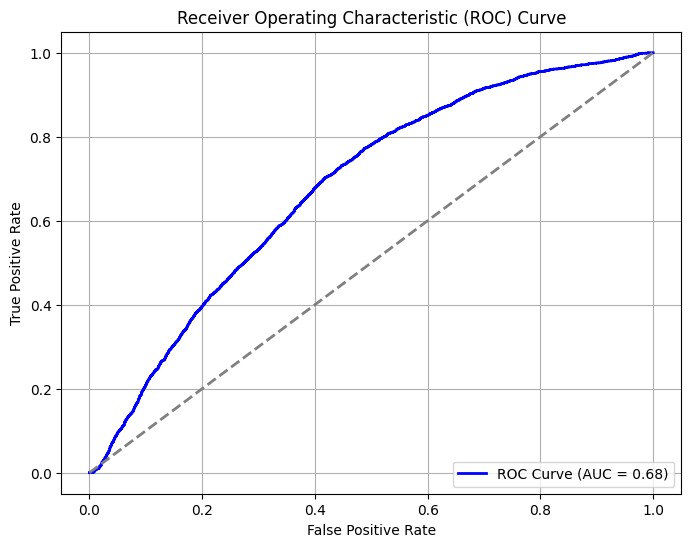

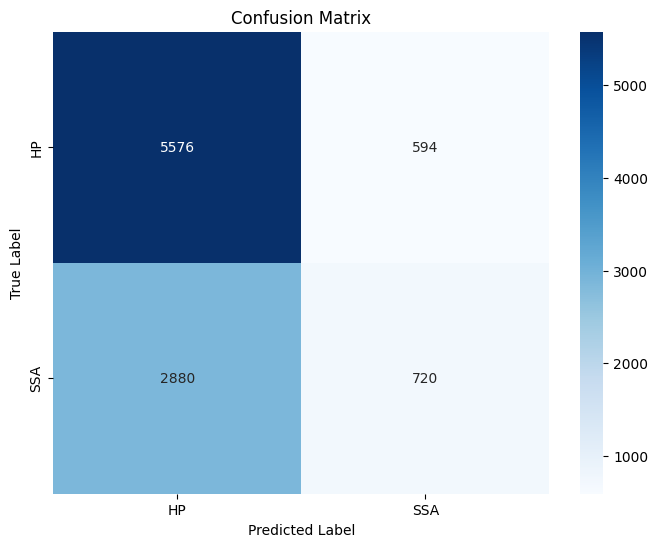

Final Accuracy: 0.64


In [10]:
run_model(resnet18_model)

## ResNet50 Model

Epoch [1/10], Training Loss: 0.2788, Train Accuracy: 68.14%, Validation Loss: 1.0569, Val Accuracy: 63.15%
Epoch [2/10], Training Loss: 0.2111, Train Accuracy: 70.67%, Validation Loss: 0.2534, Val Accuracy: 63.15%
Epoch [3/10], Training Loss: 0.2031, Train Accuracy: 69.79%, Validation Loss: 0.2510, Val Accuracy: 63.15%
Epoch [4/10], Training Loss: 0.1905, Train Accuracy: 71.82%, Validation Loss: 0.2511, Val Accuracy: 64.18%
Epoch [5/10], Training Loss: 0.1820, Train Accuracy: 71.86%, Validation Loss: 0.2905, Val Accuracy: 63.97%
Epoch [6/10], Training Loss: 0.1786, Train Accuracy: 73.33%, Validation Loss: 0.2408, Val Accuracy: 65.30%
Epoch [7/10], Training Loss: 0.1659, Train Accuracy: 75.08%, Validation Loss: 0.2548, Val Accuracy: 63.25%
Epoch [8/10], Training Loss: 0.1607, Train Accuracy: 76.18%, Validation Loss: 0.2253, Val Accuracy: 69.91%
Epoch [9/10], Training Loss: 0.1571, Train Accuracy: 77.89%, Validation Loss: 0.2199, Val Accuracy: 70.93%
Epoch [10/10], Training Loss: 0.1489,

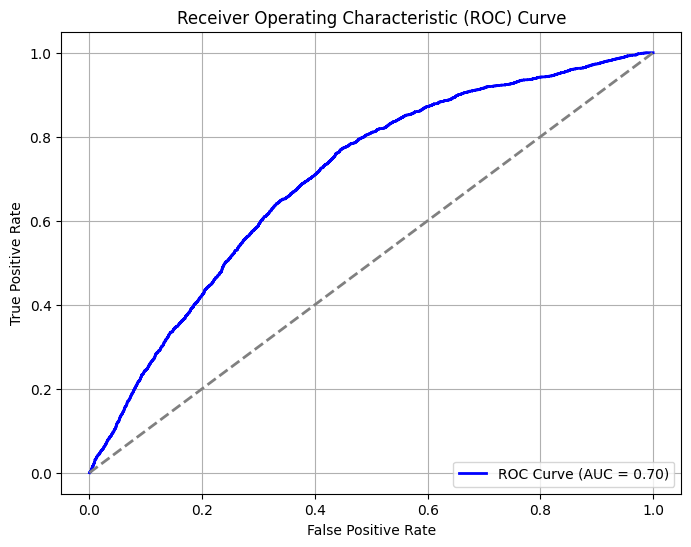

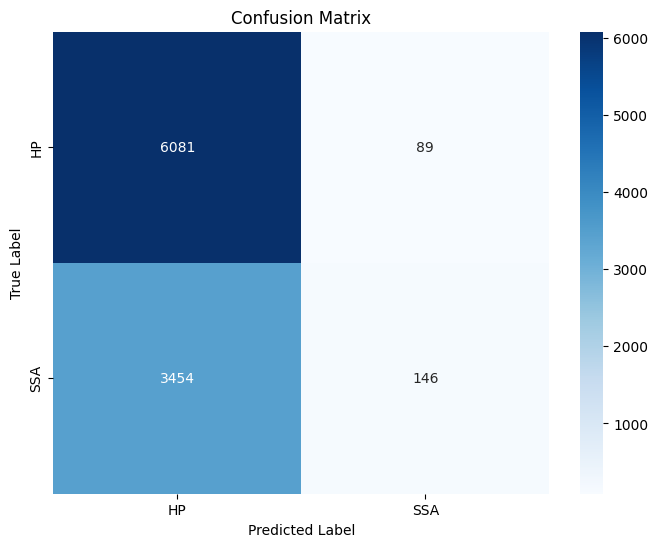

Final Accuracy: 0.64


In [11]:
run_model(resnet50_model)

## Mobile Net Model

In [ ]:
run_model(mobilenet_model)

Epoch [1/10], Training Loss: 0.1903, Train Accuracy: 70.44%, Validation Loss: 0.2471, Val Accuracy: 63.46%
Epoch [2/10], Training Loss: 0.1665, Train Accuracy: 76.14%, Validation Loss: 0.2098, Val Accuracy: 71.24%
Epoch [3/10], Training Loss: 0.1482, Train Accuracy: 80.14%, Validation Loss: 0.1962, Val Accuracy: 74.92%


## Efficient Net Model

Epoch [1/10], Training Loss: 0.1807, Train Accuracy: 74.39%, Validation Loss: 0.1858, Val Accuracy: 78.10%
Epoch [2/10], Training Loss: 0.1413, Train Accuracy: 81.93%, Validation Loss: 0.2442, Val Accuracy: 79.32%
Epoch [3/10], Training Loss: 0.1282, Train Accuracy: 83.22%, Validation Loss: 0.1612, Val Accuracy: 84.03%
Epoch [4/10], Training Loss: 0.1109, Train Accuracy: 86.34%, Validation Loss: 0.1426, Val Accuracy: 84.75%
Epoch [5/10], Training Loss: 0.0956, Train Accuracy: 88.60%, Validation Loss: 0.1704, Val Accuracy: 82.91%
Epoch [6/10], Training Loss: 0.0861, Train Accuracy: 89.89%, Validation Loss: 0.1207, Val Accuracy: 86.90%
Epoch [7/10], Training Loss: 0.0802, Train Accuracy: 90.99%, Validation Loss: 0.1416, Val Accuracy: 85.36%
Epoch [8/10], Training Loss: 0.0661, Train Accuracy: 92.69%, Validation Loss: 0.1359, Val Accuracy: 85.98%
Epoch [9/10], Training Loss: 0.0580, Train Accuracy: 93.10%, Validation Loss: 0.1326, Val Accuracy: 86.69%
Epoch [10/10], Training Loss: 0.0511,

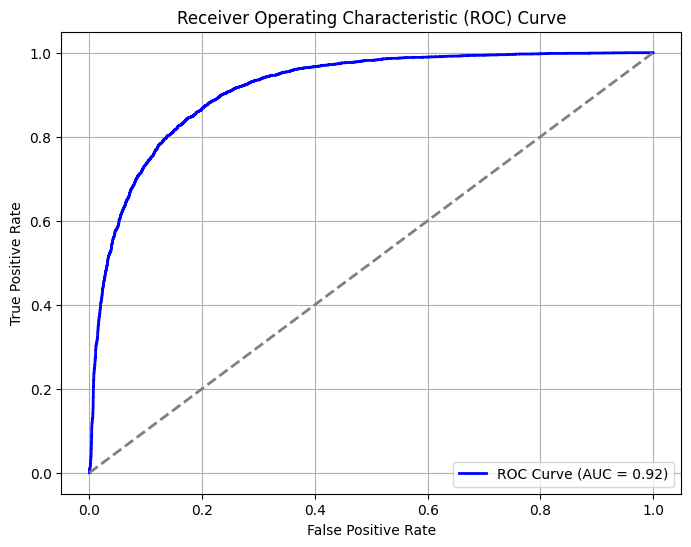

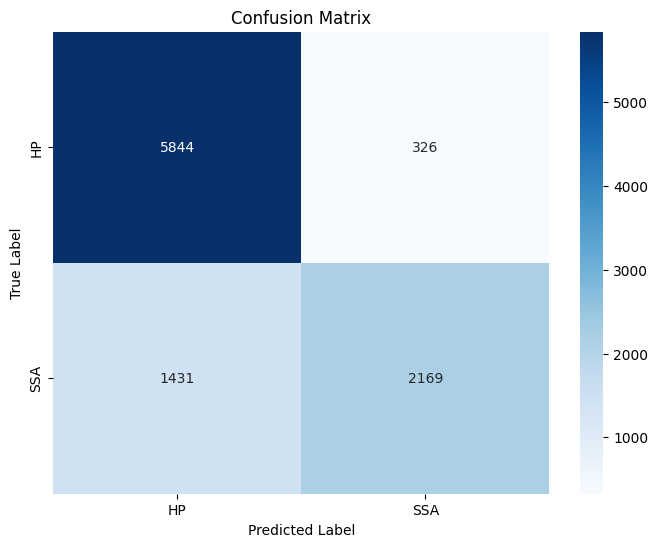

Final Accuracy: 0.82


In [10]:
run_model(efficientnet_model)